## Evaluate a custom model with a test dataset - Rémi Ançay - 2025

This notebook allows you to read and plot the results of a custom BirdNET model evaluation on a test dataset of audio files.

Configure the CSV results file path below, then run the cells. It will show some statistics and a confusion matrix of the model's predictions.

In [ ]:
# Load csv into an dataframe
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

file_name = "BirdNET_CombinedTable.csv"
test_folder = "Datasets/BarkopediaIndividualDataset/test/"


df = pd.read_csv(os.path.join(test_folder, file_name))

df.head()

,Start (s),End (s),Scientific name,Common name,Confidence,File
0,0.0,3.0,dog,10,0.9976,C:/Users/remia/OneDrive/Documents/COURS/S6/TB/...
1,0.0,3.0,dog,9,0.0011,C:/Users/remia/OneDrive/Documents/COURS/S6/TB/...
2,0.0,3.0,dog,4,0.0002,C:/Users/remia/OneDrive/Documents/COURS/S6/TB/...
3,0.0,3.0,dog,6,0.0001,C:/Users/remia/OneDrive/Documents/COURS/S6/TB/...
4,0.0,3.0,dog,3,0.0001,C:/Users/remia/OneDrive/Documents/COURS/S6/TB/...


In [34]:
#set Scientific name and Common name type to string
df['Scientific name'] = df['Scientific name'].astype(str)
df['Common name'] = df['Common name'].astype(str)

# keep only the last part of the File name (keep the last folder too)
df['File'] = df['File'].apply(lambda x: os.path.basename(os.path.dirname(x)) + "/" + os.path.basename(x))

#Create a Species with the folder name
df['Species'] = df['File'].apply(lambda x: os.path.basename(os.path.dirname(x)))

#concat "Scientific name" and "Common name" with an _ into a new Column pred
df['Pred'] = df['Scientific name'] + "_" + df['Common name']
df = df.drop(columns=['Scientific name', 'Common name'])

df.head()

,Start (s),End (s),Confidence,File,Species,Pred
0,0.0,3.0,0.9976,dog_10/combined_1.wav,dog_10,dog_10
1,0.0,3.0,0.0011,dog_10/combined_1.wav,dog_10,dog_9
2,0.0,3.0,0.0002,dog_10/combined_1.wav,dog_10,dog_4
3,0.0,3.0,0.0001,dog_10/combined_1.wav,dog_10,dog_6
4,0.0,3.0,0.0001,dog_10/combined_1.wav,dog_10,dog_3


In [35]:
#For each File in the dataframe, get the raw with the highest confidence and add it to a new df
# If there are multiple rows with the same highest confidence, keep all only the first one
predictions_df = pd.DataFrame()

for file in df['File'].unique():
    # Get the rows for the current file
    file_rows = df[df['File'] == file]
    
    # Get the row with the highest confidence
    max_confidence_row = file_rows.loc[file_rows['Confidence'].idxmax()]
    
    # Append to new dataframe
    predictions_df = pd.concat([predictions_df, pd.DataFrame([max_confidence_row])], ignore_index=True)

# rename the columns Pred to Best Prediction
predictions_df = predictions_df.rename(columns={'Pred': 'Best Prediction'})

In [36]:
print("Raw df :")
print("Number of unique files: ", df['File'].nunique())
print("Number of total files: ", df['File'].count())

print("\npredictions_df : ")
print("Number of unique files: ", predictions_df['File'].nunique())
print("Number of total files: ", predictions_df['File'].count())

Raw df :
Number of unique files:  50
Number of total files:  1000

predictions_df : 
Number of unique files:  50
Number of total files:  50


In [37]:
#Count the number of waw file in test folder recursively
test_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_folder) for f in filenames if f.endswith('.wav')]

print("Number of test file : ", len(test_files))

print("\nRatio of predictions_df to test files: ", len(predictions_df) / len(test_files) * 100, "%")

Number of test file :  50

Ratio of predictions_df to test files:  100.0 %


In [38]:
#count the number of waw files in train folder recursively
train_folder = test_folder.replace("test", "train")  # Assuming train folder is in the same structure

train_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_folder) for f in filenames if f.endswith('.wav')]
print("Number of train file : ", len(train_files))

total_files = len(test_files) + len(train_files)
print("Total number of files (train + test): ", total_files)

ratio_train_test = len(train_files) / total_files * 100
print("Ratio of train files to total files: ", ratio_train_test, "%")

Number of train file :  441
Total number of files (train + test):  491
Ratio of train files to total files:  89.81670061099797 %


In [39]:
#Search which files are not in the predictions_df

test_files_formated = [path.split('/')[-1].replace('\\', '/') for path in test_files]

missing_files = set(test_files_formated) - set(predictions_df['File'])

print("\nMissing files: ", len(missing_files))
for file in missing_files:
    print(file)


Missing files:  0


In [40]:
# Predictions with less than confidence trheshold
confidence_threshold = 0.5
low_confidence_df = predictions_df[predictions_df['Confidence'] < confidence_threshold]

print("\nLow confidence predictions (less than {}):".format(confidence_threshold))
print("Number of low confidence predictions: ", low_confidence_df.shape[0])
print(low_confidence_df[['File', 'Best Prediction', 'Confidence']])



Low confidence predictions (less than 0.5):
Number of low confidence predictions:  1
                    File Best Prediction  Confidence
46  dog_9/combined_2.wav          dog_10      0.4236


In [41]:
predictions_df.head()

,Start (s),End (s),Confidence,File,Species,Best Prediction
0,0.0,3.0,0.9976,dog_10/combined_1.wav,dog_10,dog_10
1,0.0,3.0,0.9999,dog_10/combined_2.wav,dog_10,dog_10
2,3.0,6.0,0.9999,dog_10/combined_3.wav,dog_10,dog_10
3,3.0,6.0,0.9999,dog_10/combined_4.wav,dog_10,dog_10
4,0.0,3.0,1.0000,dog_10/combined_5.wav,dog_10,dog_10


In [42]:
predictions_df["Species"].unique()

array(['dog_10', 'dog_1', 'dog_2', 'dog_3', 'dog_4', 'dog_5', 'dog_6',
       'dog_7', 'dog_8', 'dog_9'], dtype=object)

In [43]:
# Create separate bar plot for each species representing the bests predictions
def barplot_best_predictions(df):
    species_list = df['Species'].unique()
    
    for species in species_list:
        species_df = df[df['Species'] == species]
        plt.figure(figsize=(10, 6))
        sns.barplot(data=species_df, x='File', y='Confidence', hue='Best Prediction')
        plt.title(f'Best Predictions for {species}, n={len(species_df)} clips')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

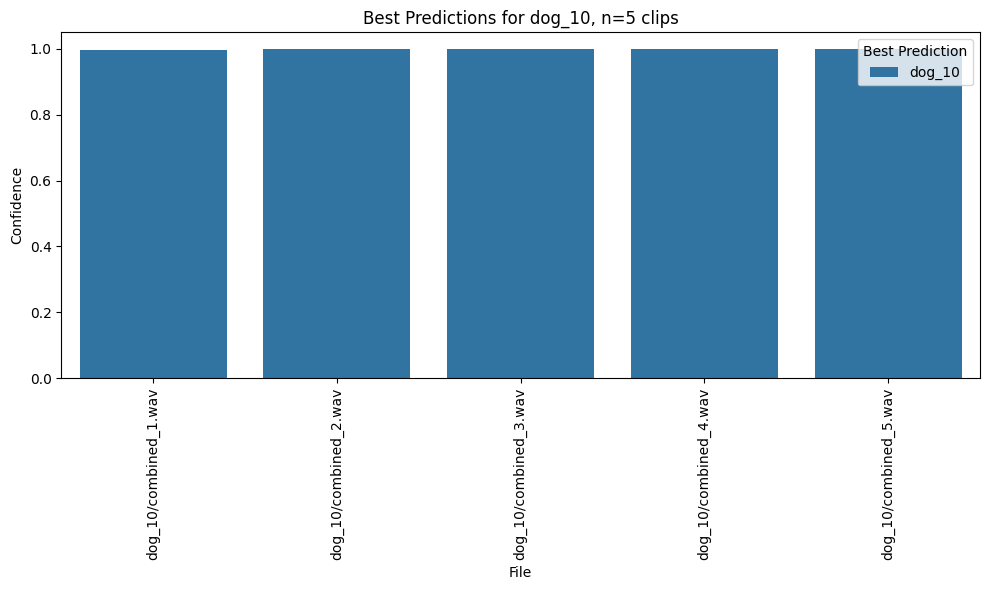

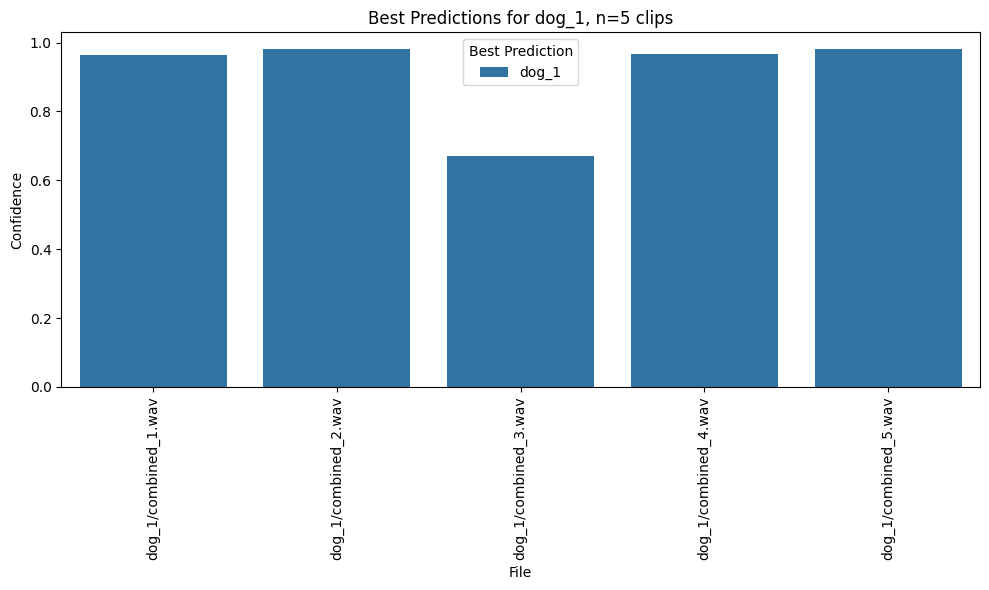

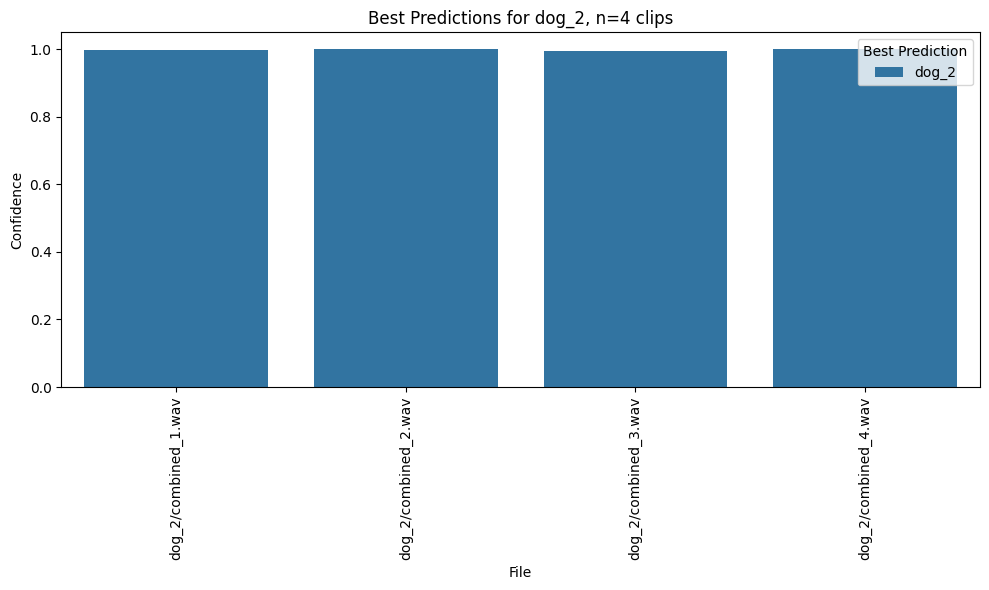

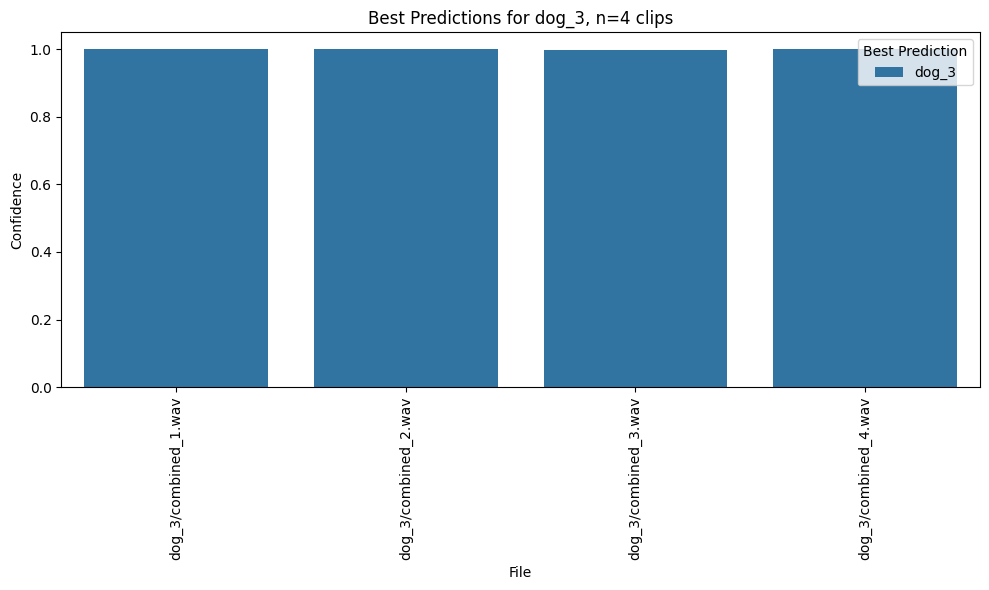

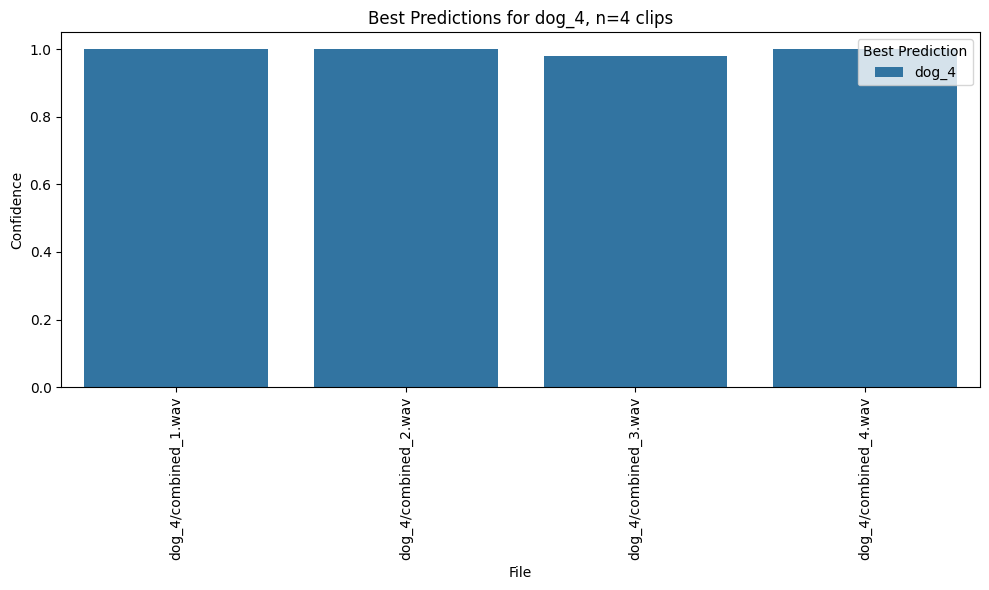

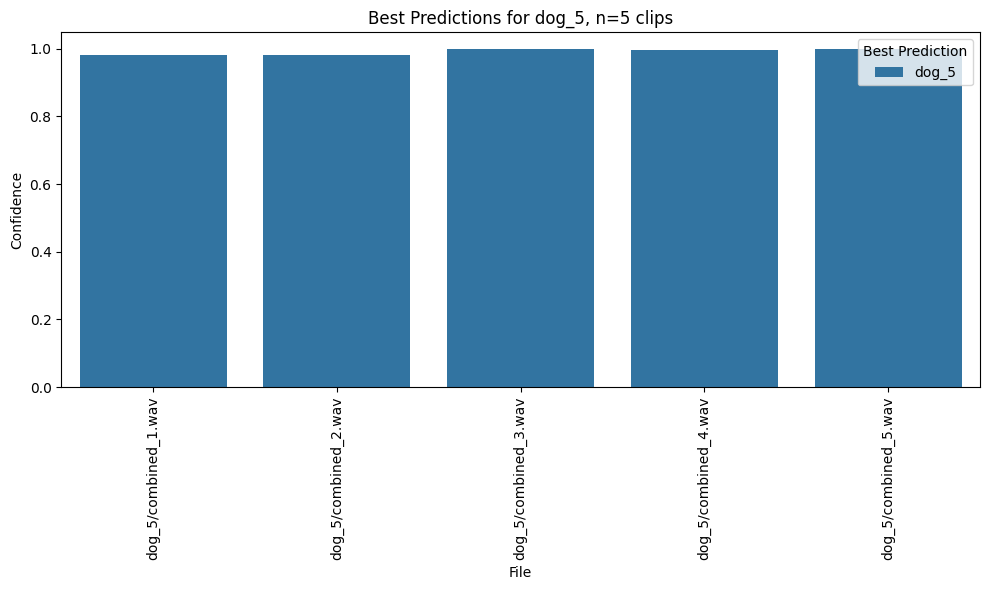

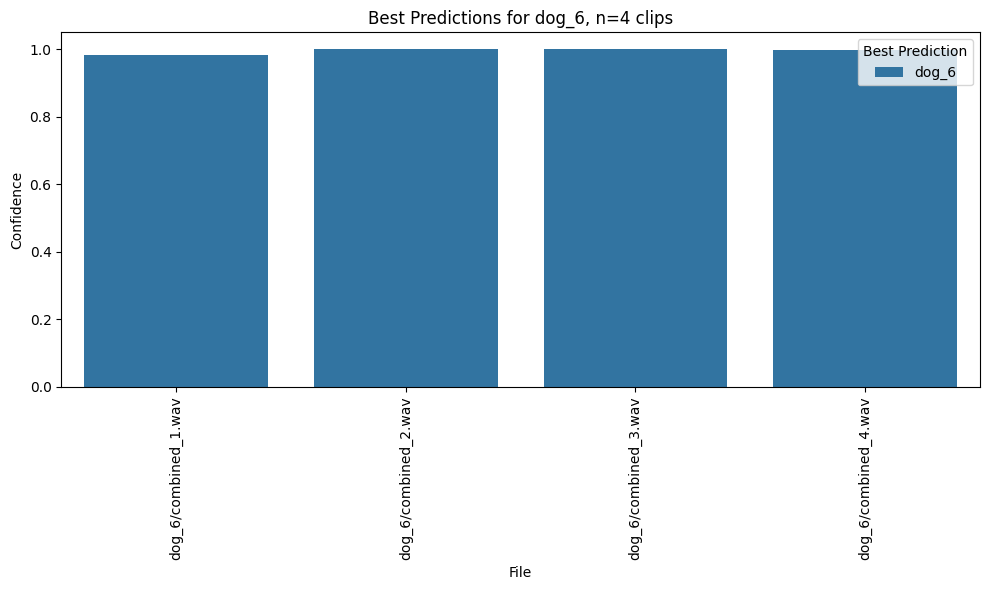

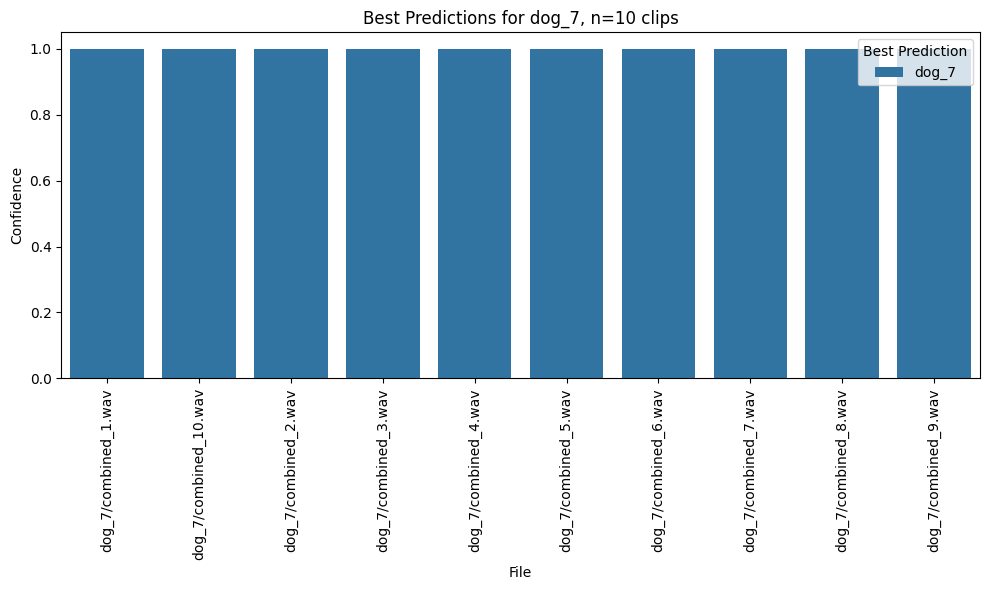

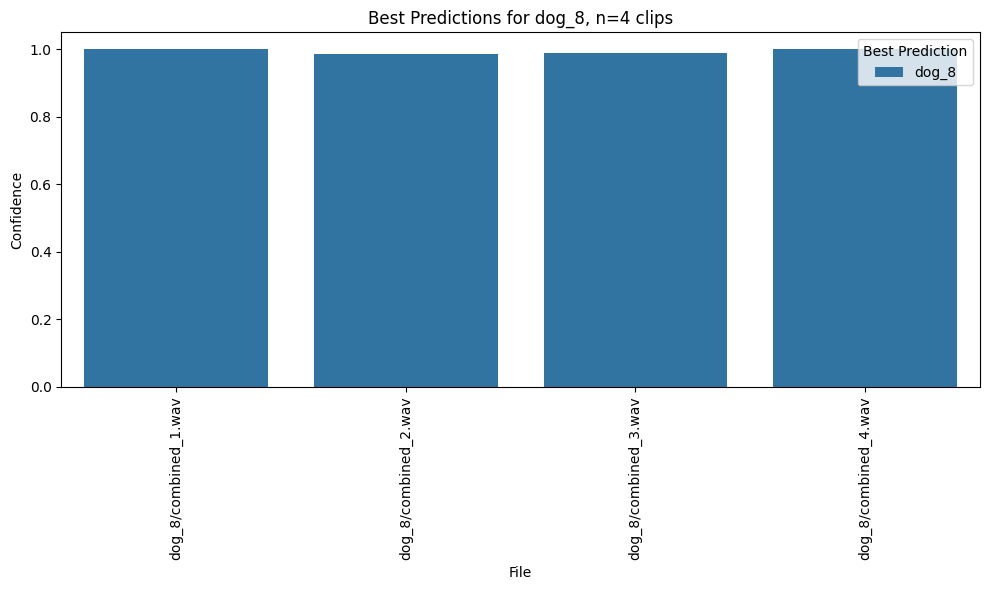

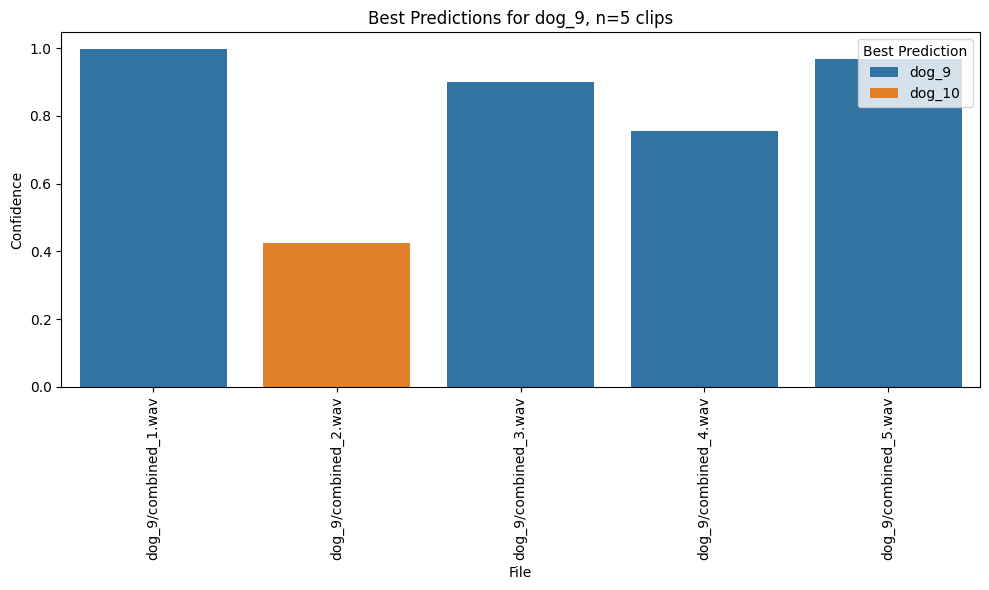

In [44]:
barplot_best_predictions(predictions_df)

In [45]:
# Create a confusion matrix for the best predictions
def confusion_matrix(df, show_report=True):
    # Create a confusion matrix
    cm = pd.crosstab(df['Species'], df['Best Prediction'], rownames=['Actual'], colnames=['Predicted'])
    
    # Normalize the confusion matrix
    cm_normalized = cm.div(cm.sum(axis=1), axis=0)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Confusion Matrix of Best Predictions')
    plt.show()

    #show classification report
    if show_report:
        from sklearn.metrics import classification_report
        y_true = df['Species']
        y_pred = df['Best Prediction']
        print(classification_report(y_true, y_pred, zero_division=0))


In [46]:
# Get accuracy for each species
def calculate_accuracy(df):
    # Count the number of correct predictions
    correct_predictions = df[df['Species'] == df['Best Prediction']]
    
    # Calculate accuracy
    accuracy = len(correct_predictions) / len(df)
    
    return accuracy

print("Accuracy : ", calculate_accuracy(predictions_df))
print("Mean confidence : ", predictions_df['Confidence'].mean())

Accuracy :  0.98
Mean confidence :  0.96956


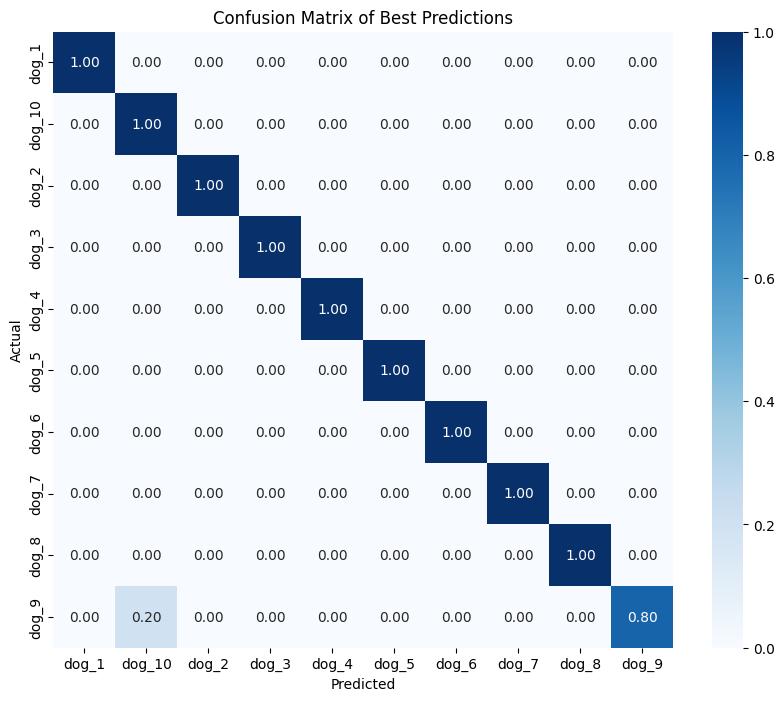

              precision    recall  f1-score   support

       dog_1       1.00      1.00      1.00         5
      dog_10       0.83      1.00      0.91         5
       dog_2       1.00      1.00      1.00         4
       dog_3       1.00      1.00      1.00         4
       dog_4       1.00      1.00      1.00         4
       dog_5       1.00      1.00      1.00         5
       dog_6       1.00      1.00      1.00         4
       dog_7       1.00      1.00      1.00        10
       dog_8       1.00      1.00      1.00         4
       dog_9       1.00      0.80      0.89         5

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



In [47]:
confusion_matrix(predictions_df)

In [48]:
#Show exemple of incorrect predictions
def show_incorrect_predictions(df):
    incorrect_df = df[df['Species'] != df['Best Prediction']]
    
    if incorrect_df.empty:
        print("No incorrect predictions found.")
        return
    
    print(f"Number of incorrect predictions: {len(incorrect_df)} / {len(df)}\n")
    print("Mean confidence of incorrect predictions: ", incorrect_df['Confidence'].mean())
    print("Mean confidence of correct predictions: ", df[df['Species'] == df['Best Prediction']]['Confidence'].mean())

    print("\nIncorrect predictions:")
    
    for index, row in incorrect_df.iterrows():
        print(f"File: {row['File']},\t Actual: {row['Species']},\t Predicted: {row['Best Prediction']},\t Confidence: {row['Confidence']}")



show_incorrect_predictions(predictions_df)

Number of incorrect predictions: 1 / 50

Mean confidence of incorrect predictions:  0.4236
Mean confidence of correct predictions:  0.9807020408163265

Incorrect predictions:
File: dog_9/combined_2.wav,	 Actual: dog_9,	 Predicted: dog_10,	 Confidence: 0.4236
